In [1]:
import netCDF4
from netCDF4 import Dataset
import os
from os.path import dirname
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib 
import matplotlib.pyplot as plt
from math import pi
from numpy import cos,sin
from scipy.spatial import cKDTree
from numpy import absolute as abs
import numpy.ma as ma

In [2]:
## Chose folder, resolution and dataset

resolution = '10m' # Change border resolution for the maps. Insert value in meters (e.g. '110m')
folder = dirname(dirname(os.getcwd())) + '\\Data_WQ\\' #The folder where the datasets are

'''
Choose the dataset:
    1: CHL-model
    2: CHL-satellite
    3: DOXYL-model
    4: NITR-model
    5: PHOS-model
    6: SPM-satellite
'''
num_dataset = 1 #Change the number here

In [3]:
## Open dataset and store variables in var_values dictionary. Units are in var_units dictionary. Names in var_names

# Open dataset
if num_dataset == 2:
    file = folder + "dataset-CHL-satellite-daily.nc"
    selected_variable = 'CHL'
    text = 'Mass concentration of chlorophyll-a in sea water - satellite'
elif num_dataset == 3:
    file = folder + "dataset-DOXYL-model-daily.nc"
    selected_variable = 'o2'
    text = 'Mole concentration of dissolved molecular oxygen in sea water - model'
elif num_dataset == 4:
    file = folder + "dataset-NITR-model-daily.nc"
    selected_variable = 'no3'
    text = 'Mole concentration of nitrate in sea water - model'
elif num_dataset == 5:
    file = folder + "dataset-PHOS-model-daily.nc"
    selected_variable = 'po4'
    text = 'Mole concentration of phosphate in sea water - model'
elif num_dataset == 6:
    file = folder + "dataset-SPM-satellite-monthly.nc"
    selected_variable = 'SPM'
    text = 'Mass concentration of inorganic suspended matter in sea water - satellite'
else:
    file = folder + "dataset-CHL-model-daily.nc"
    selected_variable = 'chl'
    text = 'Mass concentration of chlorophyll-a in sea water - model'

dataset = Dataset(file, "r")
print('Using dataset {}'.format(file))

# Save variables, units and names
var_values = {}
var_units = {}
var_names = {}
for k in dataset.variables.keys():
    # Standardize keys 'latitude' and 'longitude'
    if k == 'lat':
        k_new = 'latitude'
    elif k == 'lon':
        k_new = 'longitude'
    else:
        k_new = k
  
    var_units[k_new] = dataset.variables[k].units # Save units
    var_names[k_new] = dataset.variables[k].long_name # Save name
    if 'time' in var_names[k_new]: #Save time
        var_values[k_new] = netCDF4.num2date(dataset.variables[k][:],var_units[k_new], only_use_cftime_datetimes=False, only_use_python_datetimes = True)
    else:
        var_values[k_new] = dataset.variables[k][:]
    
    # Remove single-dimensional entries
    var_values[k_new] = np.squeeze(var_values[k_new])
        
# Close dataset
dataset.close()

Using dataset C:\Users\Rafael\Google Drive\Rafi\Delft\Mathematical Data Science\Project\Data_WQ\dataset-CHL-model-daily.nc


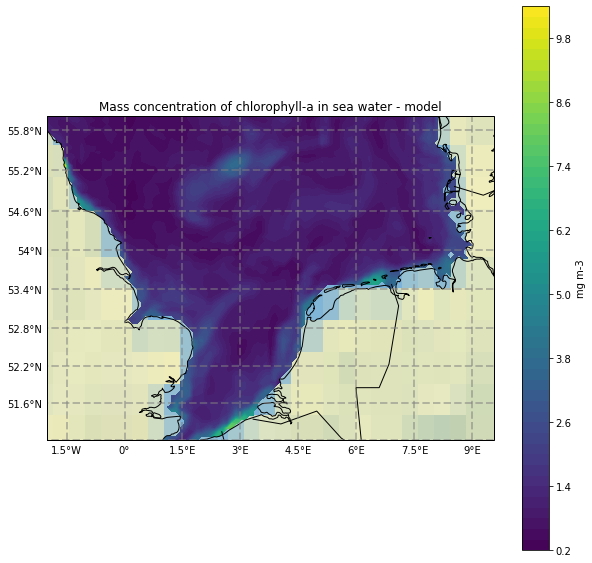

In [10]:
## Plot

# Choose timestep
timestep=100

# Take values of variable at timestep
var_plot = var_values[selected_variable][timestep,:,:]

# Initialize plot
matplotlib.rcParams['figure.figsize'] = (10,10) 

# Initialize map
proj=ccrs.Mercator()
m = plt.axes(projection=proj)

# Format map
m.stock_img()
#m.coastlines(resolution='110m')
m.coastlines(resolution=resolution)
m.add_feature(cfeature.BORDERS)
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot data
plt.contourf(var_values['longitude'], var_values['latitude'], var_plot, 60,
             transform=ccrs.PlateCarree())

# Add Colorbar
cbar = plt.colorbar()
cbar.set_label(var_units[selected_variable])

# Add Title
plt.title(text)
plt.show()

In [75]:
## Check region

ylat_north = 53.8
ylat_south = 52.8
xlon_east = 8
xlon_west = 4.2

# Create empty arrays
var_sub=np.full([int(var_values[selected_variable].shape[0]), int(var_values[selected_variable].shape[1]), int(var_values[selected_variable].shape[2])], np.nan)
lat_sub=np.full(int(var_values[selected_variable].shape[1]), np.nan)
lon_sub=np.full(int(var_values[selected_variable].shape[2]), np.nan)

# Check if measurement is between the selected region coordinates: a new matrix var_sub is created for the region, containing only the data for that specific subdomain along with NaNs everywhere else
for j in range(0,int(var_values[selected_variable].shape[2])): #Longitude
    check_lon = var_values['longitude'][j]
               
    for i in range(0,int(var_values[selected_variable].shape[1])): #Latitude
        check_lat = var_values['latitude'][i]
                   
        if check_lat <= ylat_north and check_lat >= ylat_south and check_lon >= xlon_west and check_lon <= xlon_east:      
            lat_sub[i] = check_lat
            lon_sub[j] = check_lon
            var_sub[:,i,j] = var_values[selected_variable][:,i,j]
        else:
            pass
var_sub = ma.masked_values(var_sub, var_values[selected_variable].fill_value)

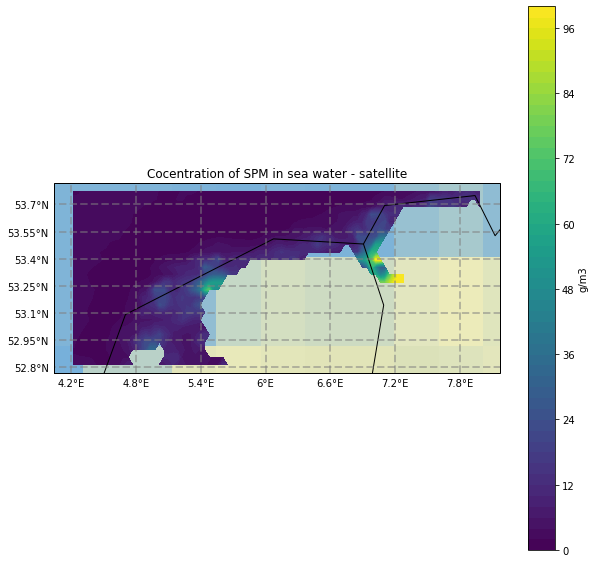

In [76]:
## Plot region

# Choose timestep
timestep=100

# Take values of variable at timestep
var_subplot = var_sub[timestep,:,:]

# Initialize plot
matplotlib.rcParams['figure.figsize'] = (10,10) 

# Initialize map
proj=ccrs.Mercator()
m = plt.axes(projection=proj)

# Format map
m.stock_img()
m.coastlines(resolution=resolution)
m.add_feature(cfeature.BORDERS)
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot data
plt.contourf(lon_sub, lat_sub, var_subplot, 60,transform=ccrs.PlateCarree())

# Add Colorbar
cbar = plt.colorbar()
cbar.set_label(var_units[selected_variable])

# Add Title
plt.title(text)
plt.show()

Exact Location lat-lon: [56, 4.77753]
Closest lat-lon: 56.0008 4.77753
Array indices [iy,ix]= 75 61


Text(0.5, 1.0, 'Mass concentration of chlorophyll-a in sea water - model at Lon=4.78, Lat=56.00')

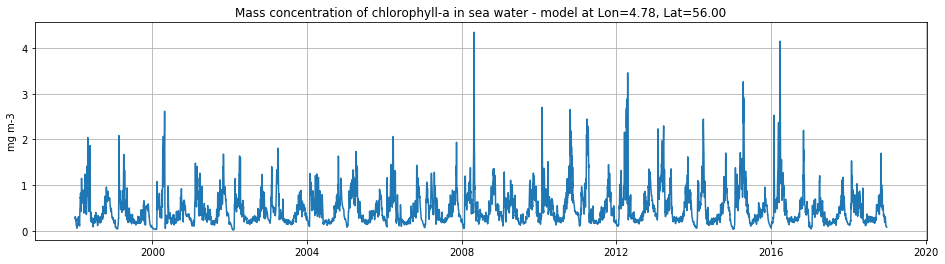

In [4]:
# Time series at given coordinates

# Choose coordinates
lon = 4.77753 
lat = 56

# Find the nearest latitude and longitude
lat_idx = np.abs(var_values['latitude'] - lat).argmin()
lon_idx = np.abs(var_values['longitude'] - lon).argmin()
print('Exact Location lat-lon:', [lat,lon])
print('Closest lat-lon:', var_values['latitude'][lat_idx], var_values['longitude'][lon_idx])
print('Array indices [iy,ix]=', lat_idx, lon_idx)   

# Get all time records of variable at indices [iy,ix]
all_records_coordinates = var_values[selected_variable][:,lat_idx,lon_idx]

# Plot time series
plt.figure(figsize=(16,4))
plt.plot_date(var_values['time'],all_records_coordinates,fmt='-')
plt.grid()
plt.ylabel(var_units[selected_variable])
plt.title('%s at Lon=%.2f, Lat=%.2f' % (text, var_values['longitude'][lon_idx], var_values['latitude'][lat_idx]))

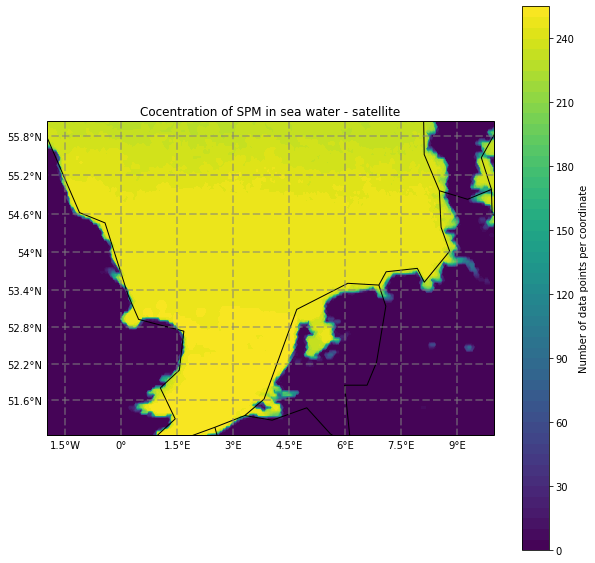

In [78]:
## Number of datapoints per coordinate
lat = var_values['latitude'].data
lon = var_values['longitude'].data

# Count unmasked measurements per coordinate
count_var_coordinate = np.zeros([var_values['latitude'].size, var_values['longitude'].size])
for i in range(var_values['latitude'].size):
    for j in range(var_values['longitude'].size):
        count_var_coordinate[i,j] = var_values[selected_variable][:,i,j].count()
        
# Initialize plot
matplotlib.rcParams['figure.figsize'] = (10,10) 

# Initialize map
proj=ccrs.Mercator()
m = plt.axes(projection=proj)

# Format map
m.stock_img()
m.coastlines(resolution=resolution)
m.add_feature(cfeature.BORDERS)
gl=m.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot data
plt.contourf(lon, lat, count_var_coordinate, 60,transform=ccrs.PlateCarree())

# Add Colorbar
cbar = plt.colorbar()
cbar.set_label('Number of data points per coordinate')

# Add Title
plt.title(text)
plt.show()